参考  
https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/2_Image_Video/2_2_torchvision_finetuning_instance_segmentation_jp.ipynb  
https://torch.classcat.com/category/mask-r-cnn/


In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torchinfo import summary

from PIL import Image


[データDL](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip)  
PyTorchチュートリアル「[Torchvisionを利用した物体検出のファインチューニング手法](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/2_Image_Video/2_2_torchvision_finetuning_instance_segmentation_jp.ipynb#scrollTo=czQJx9YYhgK4)」より取得

DLファイルのディレクトリ  
`
PennFudanPed
  |-  readme.txt
  |-  Added-object-list.txt
  |-  PNGImages
  |-  PedMasks
  |-  Annotation
`

In [2]:
image_path = os.path.join('data', 'PennFudanPed', 'PNGImages')    # 画像が入っているフォルダ
print(image_path)
mask_path = os.path.join('data', 'PennFudanPed', 'PedMasks')    # マスク画像が入っているフォルダ
print(mask_path)

data/PennFudanPed/PNGImages
data/PennFudanPed/PedMasks


In [3]:
# 画像の枚数
len(os.listdir(image_path)), len(os.listdir(mask_path)), 

(170, 170)

In [ ]:
#!ls data/PennFudanPed/PNGImages/

In [4]:
!cat data/PennFudanPed/Annotation/FudanPed00001.txt

<class 'PIL.PngImagePlugin.PngImageFile'>
(536, 559, 3)


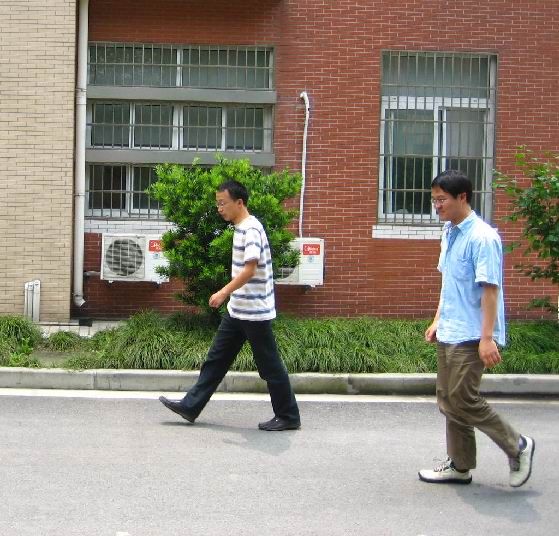

In [13]:
# 画像データ

sample_img_path = os.path.join(image_path, 'FudanPed00001.png')
sample_img = Image.open(sample_img_path)
print(type(sample_img))
print(np.array(sample_img).shape)    # numpyに変換し、次元の確認
sample_img

<class 'PIL.PngImagePlugin.PngImageFile'>
(536, 559)


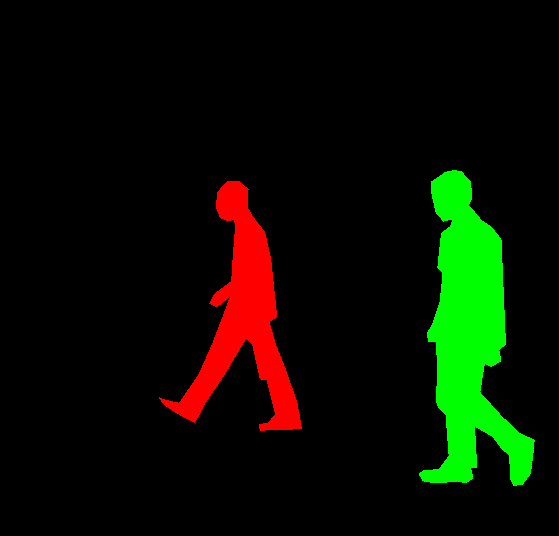

In [17]:
# マスク画像
sample_mask_path = os.path.join(mask_path, 'FudanPed00001_mask.png')
sample_mask = Image.open(sample_mask_path)
print(type(sample_mask))
print(np.array(sample_mask).shape)    # numpyに変換し、次元の確認

# 各マスクの値は、0からNまでの異なる色を持つ。Nはインスタンスの数
# 可視化のためマスクにカラーパレットを追加。でないと0（黒）に近い値なので見てもわからない
sample_mask.putpalette([
    0, 0, 0, # index0（背景）は黒
    255, 0, 0, # index1は赤
    0, 255, 0, # index2は緑
    0, 0, 255, # index3は青
])
sample_mask

In [18]:
# マスクデータの確認

print('データの形')
print(np.array(sample_mask))
print( np.array(sample_mask).shape )
print( np.array(sample_mask).shape[0] * np.array(sample_mask).shape[1] )   # ピクセル数

print('\nデータの値')
print( np.unique(np.array(sample_mask)) )   # 値の水準（0：背景、1：一人目、2：二人目）
print( np.sum(np.array(sample_mask) == 0) )    # 0のピクセル数
print( np.sum(np.array(sample_mask) == 1) )    # 1のピクセル数
print( np.sum(np.array(sample_mask) == 2) )    # 2のピクセル数

データの形
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(536, 559)
299624

データの値
[0 1 2]
270662
11241
17721


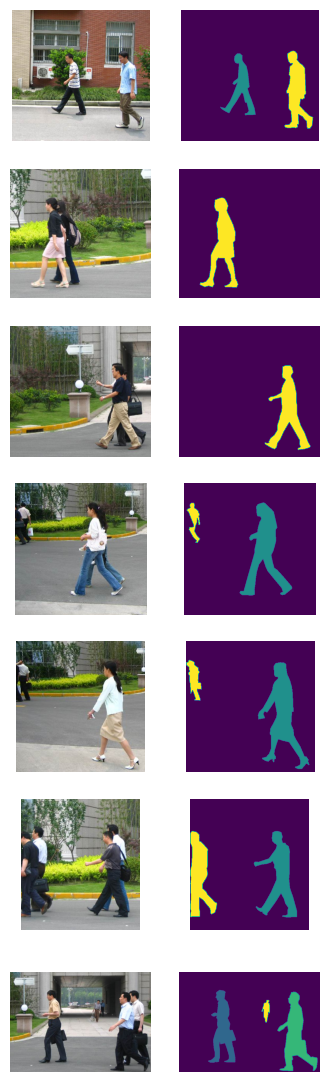

In [19]:
## 画像とマスクを並べて表示

list_size = 7
sample_img_list = sorted(os.listdir(image_path))[:list_size]       # フォルダ内の画像を先頭からlist_size枚取得
sample_mask_list = sorted(os.listdir(mask_path))[:list_size]      # フォルダ内のマスクを先頭からlist_size枚取得
#print(sample_img_list, sample_mask_list)

fig = plt.figure(figsize = (4,list_size*2))
for i,(img,mask) in enumerate(zip(sample_img_list, sample_mask_list)):
    #print(i,img,mask)
    ax_img = fig.add_subplot(list_size, 2, i*2+1)
    sample_img = Image.open(os.path.join(image_path, img)).convert('RGB')
    ax_img.axis("off")
    ax_img.imshow(sample_img)
    ax_mask = fig.add_subplot(list_size, 2, i*2+2)
    sample_mask = Image.open(os.path.join(mask_path, mask))
    ax_mask.imshow(sample_mask)
    ax_mask.axis("off")

In [20]:
## カスタムDatasetの作成
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, image_path, mask_path, transforms=None):
        self.image_path = image_path    # 画像ファイルパス
        self.mask_path = mask_path       # マスクファイルパス
        self.images = sorted(os.listdir(image_path))  # 画像ファイル名のリスト
        self.masks = sorted(os.listdir(mask_path))  # マスクファイル名のリスト
        self.transforms = transforms   # 画像の前処理やデータ拡張を実施する場合
        
    def __getitem__(self, idx):
        #>> 画像ファイル
        img_file = os.path.join(self.image_path, self.images[idx])
        img = Image.open(img_file).convert('RGB')
        #print(type(img), np.array(img).shape)
        
        #>> マスクファイル
        mask_file = os.path.join(self.mask_path, self.masks[idx])
        mask = Image.open(mask_file)    # maskはモノクロで、1~Nの値で、インスタンスを表現
        #print(type(mask), np.array(mask).shape)
        mask = np.array(mask)
        obj_ids = np.unique(mask)  # [0,1,2,..]  0が背景
        obj_ids = obj_ids[1:]            # [1,2,..]    背景を削除（インスタンス（人）の連番）
        masks = mask == obj_ids[:, None, None]    # maskに0（背景）が入ってればFalse、0以外の値だとTrue。maskと同じshapeの配列。それをインスタンス（人物）ごとに作成

        #>> バウンディングボックスの作成
        num_objs = len(obj_ids)   # 画像内のインスタンスの数
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])   # i番目のインスタンス（人物）のインデックス（縦の座標,横の座標）を返す
            xmin = np.min(pos[1])    # ボックスの左辺
            xmax = np.max(pos[1])  # ボックスの右辺
            ymin = np.min(pos[0])    # ボックスの底辺
            ymax = np.max(pos[0])  # ボックスの上辺
            boxes.append([xmin, ymin, xmax, ymax])     # 各インスタンスのバウンディングボックスの座標
        boxes = torch.as_tensor(boxes, dtype=torch.float32)  # torch.Tensorへ変換
        
        labels = torch.ones((num_objs,), dtype=torch.int64)   # インスタンスの数だけtensor([1, 1])といったベクトルを作成。今回は人物だけなので1だけ
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)     # True/Falseを0/1のtorch.Tensorへ変換
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])   # ボックスの面積。縦の長さ*横の長さ
        
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target     # img: PIL.Image形式の入力画像、target: マスクやバウンディングボックス情報
        
    def __len__(self):
        return len(self.images)
    

In [21]:
# np.whereの箇所の動作確認

mask = np.array(sample_mask)
obj_ids = np.unique(mask)[1:]
masks = mask == obj_ids[:, None, None]

print(masks)     # インスタンスごとにTrue/Falseの行列が返る
print(masks.shape)

print('')

print(masks[0])     # インスタンス0のTrue/False行列
print(np.where(masks[0]))   # Trueの箇所のインデックスを返す（縦のインデックス番号, 横のインデックス番号）

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]
(3, 381, 539)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False

np.whereに関して：https://python.atelierkobato.com/where/

In [24]:
## PennFudanDatasetの動作検証

dataset = PennFudanDataset(image_path, mask_path)
sample0 = dataset[0]
print(sample0)

print('\n----------------  img  ----------------')
print(type(sample0[0]))     # インプット画像
print(np.array(sample0[0]).shape)

print('\n----------------  target  ----------------')
print(sample0[1]['boxes'])   # インスタンス数分のバウンディングボックス（上下左右）
print(sample0[1]['boxes'].size())
print(sample0[1]['labels'])   # 人であることを示すベクトル。今回は1のみ
print(sample0[1]['masks'].size())   # インスタンスを示す0/1の行列。インスタンス数分の次元
print(sample0[1]['image_id'])   # 投入したインデックス番号
print(sample0[1]['area'])   # 各インスタンスのバウンディングボックスの面積
print(sample0[1]['iscrowd'])

(<PIL.Image.Image image mode=RGB size=559x536 at 0x7FC0B967AD90>, {'boxes': tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]]), 'labels': tensor([1, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([0]), 'area': tensor([35358., 36225.]), 'iscrowd': tensor([0, 0])})

----------------  img  ----------------
<class 'PIL.Image.Image'>
(536, 559, 3)

----------------  target  ----------------
tensor([[159., 181., 301., 430.],
        [419., 170., 534., 485.]])
torch.Size([2, 4])
tensor([1, 1])
torch.Size([2, 536, 559])
tensor

In [27]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchinfo import summary

In [28]:
def get_instance_segmentation_model(num_classes):
    # 事前学習インスタンス・セグメンテーションモデルのロード
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # 分類器に入力する特徴量の数を取得します
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # 事前訓練済みのヘッドを新しいヘッドに置き換えます
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # セグメンテーション・マスクの分類器に入力する特徴量の数を取得します
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # セグメテーション・マスクの推論器を新しいものに置き換えます
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

> [Object Detection, Instance Segmentation](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection)
>> Object Detection. [Faster R-CNN](https://pytorch.org/vision/stable/models/faster_rcnn.html)  
>
>> Instance Segmentation. [Mask R=CNN](https://pytorch.org/vision/stable/models/faster_rcnn.html)
>>> [maskrcnn_resnet50_fpn](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn.html)

In [29]:
torchvision.models.detection.maskrcnn_resnet50_fpn()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [30]:
summary(torchvision.models.detection.maskrcnn_resnet50_fpn(), (5,3,536, 559))    # （B,C,H,W）のデータを投入した場合の挙動

Layer (type:depth-idx)                                  Output Shape              Param #
MaskRCNN                                                --                        --
├─GeneralizedRCNNTransform: 1-1                         --                        --
├─BackboneWithFPN: 1-2                                  [5, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [5, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [5, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [5, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [5, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [5, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [5, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [5, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

In [32]:
torchvision.models.detection.maskrcnn_resnet50_fpn().roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
  (mask_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (mask_head): MaskRCNNHeads(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [34]:
get_instance_segmentation_model(num_classes=2)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [57]:
summary(get_instance_segmentation_model(num_classes=2), (5,3,536, 559))

Layer (type:depth-idx)                                  Output Shape              Param #
MaskRCNN                                                --                        --
├─GeneralizedRCNNTransform: 1-1                         --                        --
├─BackboneWithFPN: 1-2                                  [5, 256, 13, 14]          --
│    └─IntermediateLayerGetter: 2-1                     [5, 2048, 25, 27]         --
│    │    └─Conv2d: 3-1                                 [5, 64, 400, 432]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [5, 64, 400, 432]         --
│    │    └─ReLU: 3-3                                   [5, 64, 400, 432]         --
│    │    └─MaxPool2d: 3-4                              [5, 64, 200, 216]         --
│    │    └─Sequential: 3-5                             [5, 256, 200, 216]        (212,992)
│    │    └─Sequential: 3-6                             [5, 512, 100, 108]        1,212,416
│    │    └─Sequential: 3-7              

[こちらの追加プログラム](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/2_Image_Video/2_2_torchvision_finetuning_instance_segmentation_jp.ipynb#scrollTo=UYDb7PBw55b-)をprogramsディレクトリに保存

エラーの際、[](https://discuss.pytorch.org/t/transforms-helper-function-has-no-attribute-totensor/153985/3)

`
programs
  |-  transforms.py
  |-  ....
`

In [35]:
import programs.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())   # PIL imageをPyTorch Tensorに変換
    if train:
        # 訓練中、データオーギュメンテーションとして、訓練用の画像と正解のバウンディング・ボックスをランダム確率で水平に反転させる
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [36]:
# 作成したカスタム・データセット
dataset = PennFudanDataset(image_path, mask_path, get_transform(train=True))
dataset_test = PennFudanDataset(image_path, mask_path, get_transform(train=False))

In [37]:
# PennFudanDatasetの__getitem__のimgの返値がtorch.Tensorとなっている（PIL.Imageから変換）
print(type(dataset[0][0]))

dataset[0][0]

<class 'torch.Tensor'>


tensor([[[0.5804, 0.5725, 0.5608,  ..., 0.8314, 0.8235, 0.8275],
         [0.5020, 0.5020, 0.4941,  ..., 0.6667, 0.6784, 0.7020],
         [0.5098, 0.5137, 0.5098,  ..., 0.7373, 0.7608, 0.8000],
         ...,
         [0.7255, 0.7216, 0.7176,  ..., 0.8275, 0.8510, 0.8863],
         [0.7294, 0.7333, 0.7333,  ..., 0.8235, 0.8588, 0.9059],
         [0.7333, 0.7451, 0.7451,  ..., 0.8431, 0.8902, 0.8824]],

        [[0.3961, 0.3882, 0.3765,  ..., 0.7882, 0.7804, 0.7843],
         [0.3176, 0.3176, 0.3098,  ..., 0.6235, 0.6353, 0.6588],
         [0.3255, 0.3294, 0.3255,  ..., 0.6941, 0.7176, 0.7569],
         ...,
         [0.7255, 0.7216, 0.7176,  ..., 0.8039, 0.8275, 0.8627],
         [0.7294, 0.7333, 0.7333,  ..., 0.8000, 0.8353, 0.8824],
         [0.7333, 0.7451, 0.7451,  ..., 0.8196, 0.8667, 0.8588]],

        [[0.3255, 0.3176, 0.3059,  ..., 0.7176, 0.7098, 0.7137],
         [0.2471, 0.2471, 0.2392,  ..., 0.5529, 0.5647, 0.5882],
         [0.2549, 0.2588, 0.2549,  ..., 0.6235, 0.6471, 0.

In [38]:
# データセットを訓練セットとテストセットに分割
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [47]:
import programs.utils as U

# 訓練データと評価データのデータロード用オブジェクトを用意
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=10, 
    shuffle=True, 
    num_workers=0,
    collate_fn=U.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, 
    batch_size=1, 
    shuffle=False, 
    num_workers=0,
    collate_fn=U.collate_fn)

In [48]:
#???  num_workers      https://qiita.com/muramasa2/items/7cecaad5cd31ddc98042

In [49]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [58]:
# 作成したカスタム・データセットのクラスは、背景と人の2クラスのみです
num_classes = 2

# 補助関数を使って、モデルを取得します
model = get_instance_segmentation_model(num_classes)
type(model)

torchvision.models.detection.mask_rcnn.MaskRCNN

In [52]:
# モデルを正しいデバイス(GPU/CPU)に移動します
#model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [59]:
# オプティマイザを定義します
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr=0.005,
                            momentum=0.9, 
                            weight_decay=0.0005)

In [60]:
# 3エポックごとに学習率が1/10になるように学習率スケジューラを定義します
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [61]:
from programs.engine import train_one_epoch, evaluate

# 10エポックで訓練してみましょう
num_epochs = 1

for epoch in range(num_epochs):
    # １エポックの訓練につき、10イテレーションごとにprintします
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # 学習率の更新
    lr_scheduler.step()
    # テストデータセットの評価
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/12]  eta: 0:35:02  lr: 0.000459  loss: 3.6601 (3.6601)  loss_classifier: 0.4992 (0.4992)  loss_box_reg: 0.2739 (0.2739)  loss_mask: 2.8683 (2.8683)  loss_objectness: 0.0146 (0.0146)  loss_rpn_box_reg: 0.0041 (0.0041)  time: 175.2257  data: 0.1272
Epoch: [0]  [10/12]  eta: 0:05:37  lr: 0.005000  loss: 1.4807 (1.6692)  loss_classifier: 0.1799 (0.2719)  loss_box_reg: 0.2697 (0.2707)  loss_mask: 0.8496 (1.1059)  loss_objectness: 0.0149 (0.0143)  loss_rpn_box_reg: 0.0059 (0.0064)  time: 168.9787  data: 0.1532
Epoch: [0]  [11/12]  eta: 0:02:49  lr: 0.005000  loss: 1.0594 (1.5776)  loss_classifier: 0.1769 (0.2587)  loss_box_reg: 0.2584 (0.2624)  loss_mask: 0.6021 (1.0357)  loss_objectness: 0.0149 (0.0144)  loss_rpn_box_reg: 0.0059 (0.0064)  time: 169.3401  data: 0.1522
Epoch: [0] Total time: 0:33:52 (169.3404 s / it)
creating index...
index created!


AssertionError: Torch not compiled with CUDA enabled

https://qiita.com/motamura/items/e0f91afeadc2877c05c7
